In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andyzulhair","key":"a0663cf310d0ca179499247f554de392"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:12<00:00, 168MB/s]
100% 1.33G/1.33G [00:12<00:00, 115MB/s]


In [4]:
!unzip celeba-dataset.zip -d ./celeba

Streaming output truncated to the last 5000 lines.
  inflating: ./celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: ./celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: ./celeba/img_align_celeba/img_align_cel

In [5]:
# Import library utama
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Cek apakah GPU terdeteksi
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [6]:
# Tentukan path ke folder gambar dan parameter
image_dir = './celeba/img_align_celeba/img_align_celeba/'
image_size = 64  # Ukuran gambar kita set ke 64x64 piksel
batch_size = 128   # Jumlah gambar yang diproses dalam satu waktu

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(file_path):
    # Membaca file gambar
    img = tf.io.read_file(file_path)
    # Decode gambar menjadi tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize gambar ke ukuran yang kita inginkan
    img = tf.image.resize(img, [image_size, image_size])
    # Normalisasi piksel ke rentang [-1, 1]
    img = (img - 127.5) / 127.5
    return img

# Buat dataset dari file gambar di direktori
# Kita ambil 80,000 gambar pertama untuk mempercepat pelatihan awal
file_paths = [os.path.join(image_dir, fname) for fname in sorted(os.listdir(image_dir))[:80000]]
dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Dataset berhasil dibuat dengan {len(file_paths)} gambar.")

Dataset berhasil dibuat dengan 80000 gambar.


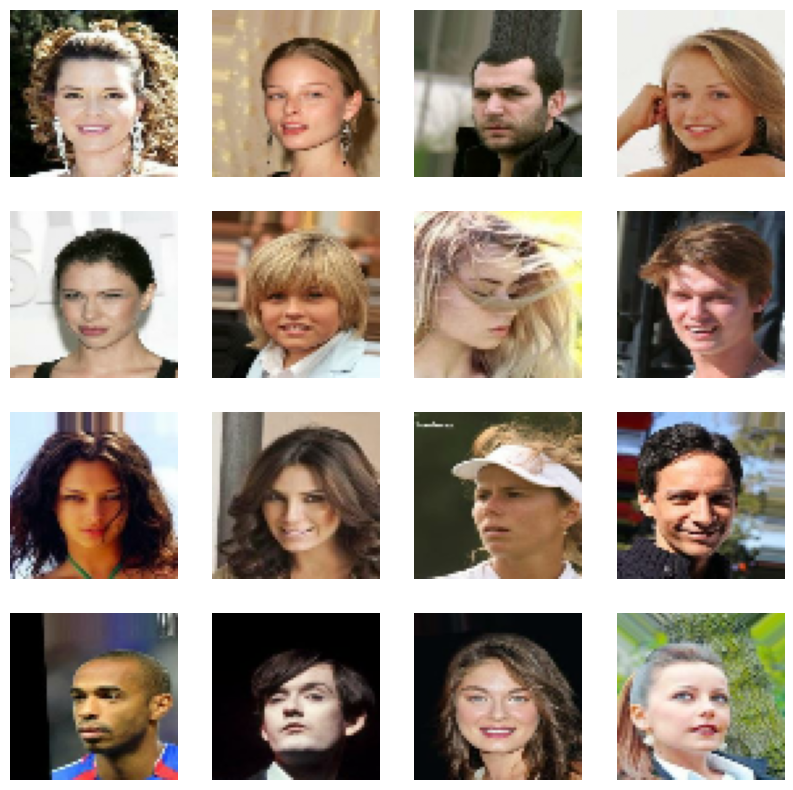

In [7]:
# Ambil satu batch dari dataset
sample_batch = next(iter(dataset))

# Tampilkan beberapa gambar
plt.figure(figsize=(10, 10))
for i in range(16): # Tampilkan 16 gambar
    ax = plt.subplot(4, 4, i + 1)
    # Denormalisasi gambar agar bisa ditampilkan dengan benar
    plt.imshow((sample_batch[i].numpy() * 0.5) + 0.5)
    plt.axis("off")
plt.show()

In [10]:
from tensorflow.keras import layers, Model, backend as K

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def build_encoder(self):
        encoder_inputs = layers.Input(shape=(64, 64, 3))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        return Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    def build_decoder(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((16, 16, 64))(x)
        # Adjust strides and padding to get output shape of 64x64
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) # Sigmoid for pixel values between 0-1
        return Model(latent_inputs, decoder_outputs, name="decoder")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Denormalize data for reconstruction loss (from [-1, 1] to [0, 1])
            normalized_data = (data + 1) / 2.0
            z_mean, z_log_var, z = self.encoder(normalized_data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(normalized_data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [11]:
# Tentukan dimensi ruang laten
latent_dim = 100

# Buat instance dari model VAE kita
vae = VAE(latent_dim)

# Compile model dengan optimizer
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Latih model!
history = vae.fit(dataset, epochs=30)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - kl_loss: 0.0716 - loss: 2748.2900 - reconstruction_loss: 2748.2178
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - kl_loss: 0.0882 - loss: 2726.8828 - reconstruction_loss: 2726.7942
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - kl_loss: 0.0467 - loss: 2725.8562 - reconstruction_loss: 2725.8091
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - kl_loss: 0.0255 - loss: 2725.1228 - reconstruction_loss: 2725.0967
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - kl_loss: 0.0154 - loss: 2725.0859 - reconstruction_loss: 2725.0715
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - kl_loss: 0.0123 - loss: 2725.0400 - reconstruction_loss: 2725.0278
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - kl_loss: 0.0098 - loss: 2724.6587 - reconstruction_loss: 2724.6494
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - kl_loss: 0.0077 - loss: 2724.3894 - reconstruction_loss: 2724.3816
Epoch 9/30
625/6

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  


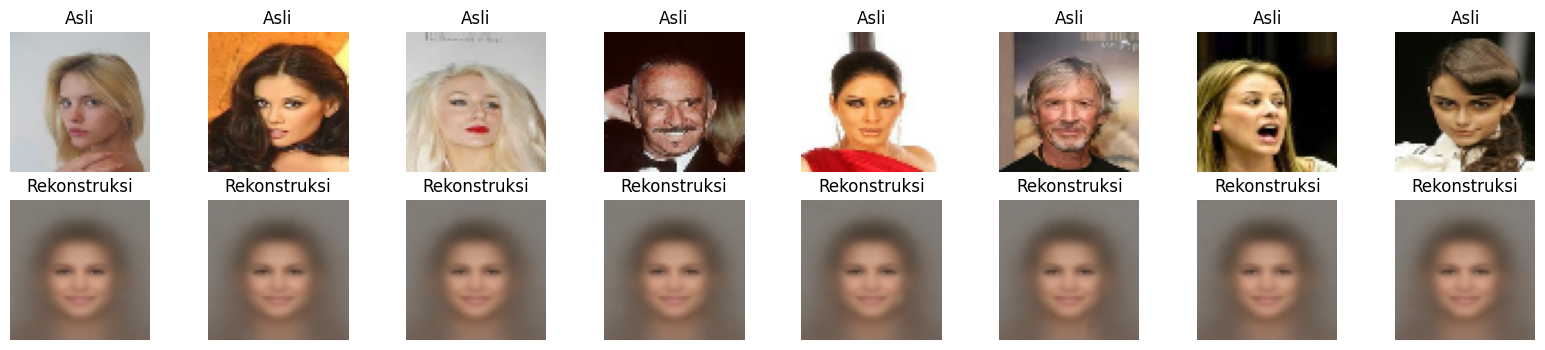

In [12]:
# Ambil satu batch dari dataset untuk diuji
test_batch = next(iter(dataset))
# Normalisasi data ke [0,1] untuk encoder
normalized_test_batch = (test_batch + 1) / 2.0

# Dapatkan hasil rekonstruksi dari model VAE
_, _, z = vae.encoder.predict(normalized_test_batch)
reconstructed_images = vae.decoder.predict(z)

# Tampilkan gambar asli vs. hasil rekonstruksi
n = 8 # Jumlah gambar yang akan ditampilkan
plt.figure(figsize=(20, 4))
for i in range(n):
    # Tampilkan gambar asli (denormalize dari [-1, 1] ke [0, 1])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((test_batch[i].numpy() * 0.5) + 0.5)
    plt.title("Asli")
    plt.axis("off")

    # Tampilkan gambar rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Rekonstruksi")
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


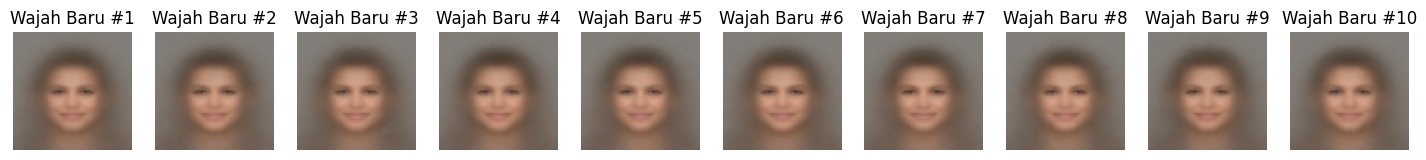

In [13]:
# Jumlah wajah baru yang ingin dibuat
n_new_faces = 10

# Buat vektor laten acak dari distribusi normal standar
random_latent_vectors = tf.random.normal(shape=[n_new_faces, latent_dim])

# Hasilkan gambar dari vektor laten acak
generated_images = vae.decoder.predict(random_latent_vectors)

# Tampilkan hasilnya
plt.figure(figsize=(18, 5))
for i in range(n_new_faces):
    ax = plt.subplot(1, n_new_faces, i + 1)
    plt.imshow(generated_images[i])
    plt.title(f"Wajah Baru #{i+1}")
    plt.axis("off")
plt.show()

Menghitung vektor 'senyum'...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Selesai!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


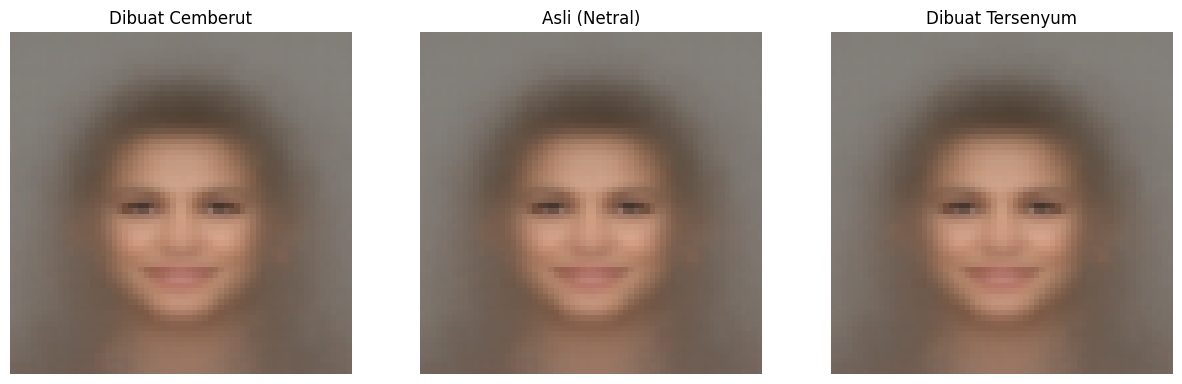

In [14]:
import pandas as pd

# Muat file atribut
attributes_file = './celeba/list_attr_celeba.csv'
df_attr = pd.read_csv(attributes_file)

# Ambil nama file untuk gambar tersenyum dan tidak tersenyum
smiling_files = df_attr[df_attr['Smiling'] == 1]['image_id'].tolist()
neutral_files = df_attr[df_attr['Smiling'] == -1]['image_id'].tolist()

# Fungsi untuk mendapatkan vektor laten rata-rata
def get_avg_latent_vector(files, num_samples=1000):
    image_paths = [os.path.join(image_dir, fname) for fname in files[:num_samples]]
    dataset_attr = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset_attr = dataset_attr.map(preprocess_image).batch(batch_size)

    # Normalisasi sebelum dimasukkan ke encoder
    normalized_dataset_attr = dataset_attr.map(lambda x: (x + 1) / 2.0)

    _, _, z = vae.encoder.predict(normalized_dataset_attr)
    return np.mean(z, axis=0)

# Hitung vektor "senyum"
print("Menghitung vektor 'senyum'...")
smile_vector = get_avg_latent_vector(smiling_files) - get_avg_latent_vector(neutral_files)
print("Selesai!")

# --- Sekarang mari kita manipulasi satu gambar ---
# Ambil satu gambar yang tidak tersenyum sebagai dasar
base_image_path = os.path.join(image_dir, neutral_files[10]) # Ambil gambar ke-10
base_image = preprocess_image(base_image_path)
base_image_batch = tf.expand_dims(base_image, axis=0)
normalized_base_image_batch = (base_image_batch + 1) / 2.0

# Dapatkan kode latennya
_, _, z_base = vae.encoder.predict(normalized_base_image_batch)

# Terapkan manipulasi
intensity = 1.5 # Seberapa kuat efeknya
z_more_smile = z_base + smile_vector * intensity
z_less_smile = z_base - smile_vector * intensity

# Hasilkan gambar-gambar baru
img_original = vae.decoder.predict(z_base)
img_more_smile = vae.decoder.predict(z_more_smile)
img_less_smile = vae.decoder.predict(z_less_smile)

# Tampilkan perbandingan
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_less_smile[0])
plt.title("Dibuat Cemberut")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_original[0])
plt.title("Asli (Netral)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_more_smile[0])
plt.title("Dibuat Tersenyum")
plt.axis('off')

plt.show()

In [15]:
# Langkah 1: Install Gradio
!pip install -q gradio

import gradio as gr

# Kita bungkus semua logika manipulasi ke dalam satu fungsi
def manipulate_face(input_image, smile_intensity):
    # Gradio memberikan input sebagai numpy array, kita perlu mengubahnya
    # menjadi format yang benar dan melakukan preprocessing
    input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_image_resized = tf.image.resize(input_image_tensor, [64, 64])
    input_image_normalized = (input_image_resized - 127.5) / 127.5
    input_image_batch = tf.expand_dims(input_image_normalized, axis=0)

    # Encoder hanya menerima data ternormalisasi [0,1]
    encoder_input = (input_image_batch + 1) / 2.0

    # Dapatkan kode laten dari gambar input
    _, _, z_base = vae.encoder.predict(encoder_input, verbose=0)

    # Terapkan manipulasi "senyum"
    z_manipulated = z_base + smile_vector * smile_intensity

    # Hasilkan gambar baru dari decoder
    manipulated_image = vae.decoder.predict(z_manipulated, verbose=0)

    return manipulated_image[0]

# Langkah 2: Buat Antarmuka (UI) Gradio
with gr.Blocks() as demo:
    gr.Markdown("# 🎨 VAE Creative Face Editor")
    gr.Markdown("Unggah gambar wajah (atau gunakan contoh di bawah) dan geser slider untuk mengubah senyumannya.")
    with gr.Row():
        image_input = gr.Image(label="Input Wajah")
        image_output = gr.Image(label="Hasil Manipulasi")
    smile_slider = gr.Slider(minimum=-2.5, maximum=2.5, step=0.1, value=1.0, label="Intensitas Senyum")

    # Hubungkan slider dan input gambar ke fungsi kita
    smile_slider.change(manipulate_face, inputs=[image_input, smile_slider], outputs=image_output)

    gr.Examples(
        examples=[os.path.join(image_dir, f) for f in neutral_files[10:15]],
        inputs=image_input
    )

# Langkah 3: Jalankan Aplikasinya!
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c04e957b7b5664b8da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c04e957b7b5664b8da.gradio.live


In [17]:

vae.encoder.save_weights("encoder_weights.weights.h5")
vae.decoder.save_weights("decoder_weights.weights.h5")